In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from tqdm import tqdm
import time

from itertools import product

In [2]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

from scipy.sparse import csr_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin 

from scipy.stats import randint

In [3]:
def min_preprocessing(actions, catalog):
    
    actions.date = pd.to_datetime(actions.date)
    actions = actions.explode('products')
    actions.products = actions.products.fillna(0)
    actions.products = actions.products.astype(int)
    actions.drop('loc_user_id', axis=1, inplace=True)
    actions.rename({'products': 'productId'}, axis=1, inplace=True)

    catalog.add_date = pd.to_datetime(catalog.add_date)
    catalog.shop_id = catalog.shop_id.astype(int)
    catalog.category_id = catalog.category_id.astype(int)
    catalog.product_id = catalog.product_id.astype(int)
    catalog.drop(['title'], axis=1, inplace=True)
    
    return actions, catalog

In [4]:
train_actions = pd.read_parquet('../data/raw/train_actions.pq', engine='pyarrow')
stokman_catalog = pd.read_parquet('../data/raw/stokman_catalog_preprocessed.pq', engine='pyarrow')

In [5]:
actions, catalog = min_preprocessing(train_actions, stokman_catalog)
del train_actions, stokman_catalog

In [6]:
users_actions = actions.groupby('user_id').agg({'action':'count'}).sort_values(by='action', ascending=False)
actions[actions.user_id.isin(users_actions.sort_values(by='action', ascending=False).index)].to_parquet('../data/processed/actions_sorted.pq')
actions_cutted = actions[actions.user_id.isin(users_actions.sort_values(by='action', ascending=False)[:10000].index)]

In [7]:
del actions, users_actions, catalog

In [8]:
catalog_cutted = pd.read_csv('../data/processed/catalog_sorted.csv')

Последний лучший: np.array([1, 5, 4, 0, 0, 10, 3, 2, 1, 1])

In [13]:
actions_test = actions_cutted[actions_cutted['date'] >= '2024-09-26']
actions_train = actions_cutted[(actions_cutted['date'] < '2024-09-26') & 
                               (actions_cutted.user_id.isin(actions_test.user_id.unique()))]
actions_test = actions_test[actions_test.user_id.isin(actions_train.user_id.unique())]

train = pd.DataFrame(index=actions_train['user_id'].unique(), 
                     columns=catalog_cutted['product_id'].unique())
test = pd.DataFrame(index=actions_test['user_id'].unique(), 
                    columns=catalog_cutted['product_id'].unique())

In [14]:
action_counts_train = actions_train.groupby(['user_id', 'productId', 'action']).size().unstack(fill_value=0).reset_index()
action_counts_train['score'] = (action_counts_train.iloc[:, 2:].values @ actions_coefs_arr)
pivot_scores_train = action_counts_train.pivot_table(values='score', index='user_id', columns='productId', fill_value=0)
train.update(pivot_scores_train)
del pivot_scores_train, action_counts_train
action_counts_test = actions_test.groupby(['user_id', 'productId', 'action']).size().unstack(fill_value=0).reset_index()
action_counts_test['score'] = (action_counts_test.iloc[:, 2:].values @ actions_coefs_arr)
pivot_scores_test = action_counts_test.pivot_table(values='score', index='user_id', columns='productId', fill_value=0)
test.update(pivot_scores_test)
del pivot_scores_test, action_counts_test

In [15]:
del actions_train, actions_test

In [16]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

C:\Users\Wh1te\AppData\Local\Temp\ipykernel_71968\4254469834.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train.fillna(0, inplace=True)
C:\Users\Wh1te\AppData\Local\Temp\ipykernel_71968\4254469834.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test.fillna(0, inplace=True)


In [36]:
class SVDRecommender(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=50, n_iter=5, random_state=42, n_oversamples=2):
        self.n_components = n_components
        self.n_iter = n_iter
        self.random_state = random_state
        self.n_oversamples = n_oversamples
        self.svd = TruncatedSVD(n_components=self.n_components, 
                                n_iter=self.n_iter, 
                                random_state=self.random_state,
                                n_oversamples=self.n_oversamples)

    def fit(self, X, y=None):
        self.svd.fit(X)
        return self

    def transform(self, X):
        return self.svd.transform(X)

    def predict(self, X):
        transformed_users = self.transform(X)
        item_factors = self.svd.components_
        
        predicted_ratings = np.dot(transformed_users, item_factors)
        return predicted_ratings

    def score(self, X, y_true):

        predicted_ratings = self.predict(X)
        rmse = root_mean_squared_error(y_true=y_true, y_pred=predicted_ratings)
        return rmse

In [37]:
param_distributions = {
    'n_components': np.arange(2, 8),
    'n_iter': [5],
    'n_oversamples': np.arange(2, 8),
}
param_combinations = list(product(param_distributions['n_components'], 
                                   param_distributions['n_iter'], 
                                   param_distributions['n_oversamples']))

rmse_results = []

for n_components, n_iter, n_oversamples in tqdm(param_combinations, desc="Обучение моделей", unit="комбинация"):
    svd = SVDRecommender(n_components=n_components, 
                         n_iter=n_iter, 
                         n_oversamples=n_oversamples)

    svd.fit(train)

    rmse = svd.score(X=test, y_true=test)
    rmse_results.append(rmse)

Обучение моделей: 100%|██████████| 36/36 [03:56<00:00,  6.57s/комбинация]


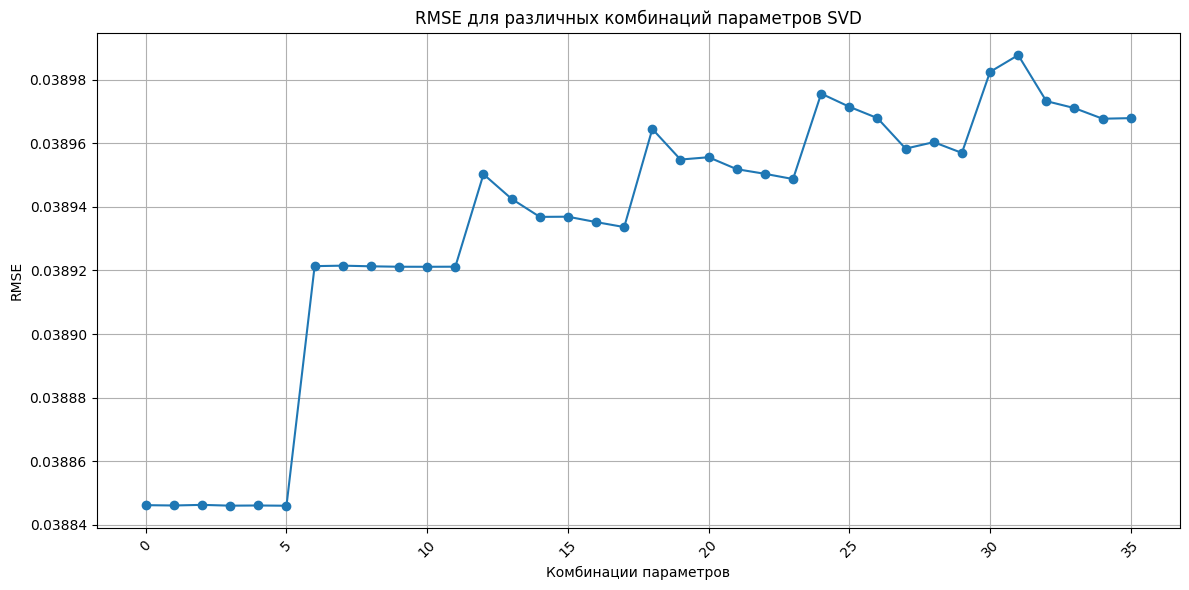

In [38]:
# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(range(len(rmse_results)), rmse_results, marker='o', linestyle='-')
plt.title('RMSE для различных комбинаций параметров SVD')
plt.xlabel('Комбинации параметров')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [39]:
del train, test

Последний лучший: np.array([1, 5, 4, 0, 0, 10, 3, 2, 1, 1])

In [51]:
actions_coefs_arr = np.array([1, 5, 4, 0, 0, 10, 3, 2, 1, 1])

In [52]:
load = pd.read_parquet('../data/processed/empty_load.pq')
action_counts_load = pd.read_csv('../data/processed/action_counts_load.csv', index_col=0)
action_counts_load['score'] = (action_counts_load.iloc[:, 2:].values @ actions_coefs_arr)
pivot_scores_load = action_counts_load.pivot_table(values='score', index='user_id', columns='productId', fill_value=0)
load.update(pivot_scores_load)
del pivot_scores_load, action_counts_load
load.fillna(0, inplace=True)

In [23]:
products_additional = pd.read_csv('../data/processed/action_couts_users_not_in_actioncutted_summed_by_product.csv')
products_additional['score'] = (products_additional.iloc[:, 2:].values @ actions_coefs_arr)
products_additional = products_additional[products_additional.score <= 100]

In [24]:
def update_scores(row):
    product_id = row['productId']
    score = row['score']
    
    if product_id in load.columns:
        load[product_id] += score

products_additional.apply(update_scores, axis=1)

1        None
2        None
3        None
4        None
5        None
         ... 
61033    None
61034    None
61035    None
61036    None
61037    None
Length: 40331, dtype: object

In [53]:
svd = TruncatedSVD(n_components=100, n_oversamples=10, random_state=42, algorithm='randomized')
svd.fit(load)

TruncatedSVD(n_components=100, random_state=42)

In [54]:
load_transformed = svd.transform(load)
item_factors = svd.components_
predicted_ratings_load = np.dot(load_transformed, item_factors)

In [55]:
results = pd.DataFrame(predicted_ratings_load, index=load.index, columns=load.columns)

In [19]:
user_cats_ordering = (
    actions_cutted
    .merge(catalog_cutted[['product_id', 'category_id']], left_on='productId', right_on='product_id', how='left')
)

category_counts = user_cats_ordering.groupby(['user_id', 'category_id']).agg({'action': 'count'}).reset_index()
category_counts = category_counts.sort_values(by='action', ascending=False)

top_25_categories = (category_counts.groupby('user_id')
                     .head(25)
                     .reset_index(drop=True))

top_25_categories.drop('action', axis=1, inplace=True)

valid_product_ids = catalog_cutted[catalog_cutted.category_id.isin(top_25_categories.category_id.unique())]['product_id']

results_sorted_cats = results[[*valid_product_ids.tolist()]]

top_25_results_with_cats = results_sorted_cats.apply(lambda x: x.nlargest(25).index.tolist(), axis=1)
top25_with_cats = top_25_results_with_cats.to_frame().reset_index().rename({'index':'user_id', 0:'products'}, axis=1)
top25_with_cats.products = top25_with_cats.products.apply(lambda elem: [str(x) for x in elem])
top25_with_cats.iloc[0:3000].to_csv('../output/predictions/SVD_with_addtions_3.csv', index=False)

In [28]:
top_25_results = results.apply(lambda x: x.nlargest(25).index.tolist(), axis=1)
top_25_results = top_25_results.to_frame().reset_index().rename({'index':'user_id', 0:'products'}, axis=1)
top_25_results.products = top_25_results.products.apply(lambda elem: [str(x) for x in elem])
top_25_results.iloc[0:3000].to_csv('../output/predictions/SVD_with_addtions_no_cats_6.csv', index=False)

In [56]:
top_25_results = results.apply(lambda x: x.nlargest(25).index.tolist(), axis=1)
top_25_results = top_25_results.to_frame().reset_index().rename({'index':'user_id', 0:'products'}, axis=1)

In [57]:
top_25_baseline = pd.read_csv('../output/predictions/predictions_baseline_new_31728855387.csv')

In [58]:
top_25_baseline.products = top_25_results.products.apply(lambda elem: [int(x) for x in elem])

In [59]:
new_results = []
for _, row in top_25_baseline.iterrows():
    user_id = row['user_id']
    products = row['products']
    
    if len(products) < 25:
        additional_products = top_25_results.loc[top_25_results['user_id'] == user_id, 'products'].values
        
        if additional_products.size > 0:
            additional_products = additional_products[0]
            products = list(set(products) | set(additional_products))
    
    new_results.append({'user_id': user_id, 'products': products[:25]})  # Ограничиваем до 25 продуктов

final_df = pd.DataFrame(new_results)

In [60]:
final_df.products = final_df.products.apply(lambda elem: [str(x) for x in elem])
final_df.iloc[0:3000].to_csv('../output/predictions/SVD+baseline_3.csv', index=False)